In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import json
import transformers
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Flatten,GlobalAveragePooling1D,LSTM,Dropout,BatchNormalization
from transformers import TFAutoModelForSequenceClassification
from transformers import TFAutoModel

In [2]:

file_path="data/train.csv" 

In [ ]:

test_file_path="data/test.csv"

In [3]:
df=pd.read_csv(file_path)


In [ ]:
df_tst=pd.read_csv(test_file_path)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189 entries, 0 to 1188
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0.1                    1189 non-null   int64  
 1   Unnamed: 0                      1189 non-null   int64  
 2   url                             1189 non-null   object 
 3   urlid                           1189 non-null   int64  
 4   boilerplate                     1189 non-null   object 
 5   alchemy_category                1189 non-null   object 
 6   alchemy_category_score          1189 non-null   object 
 7   avglinksize                     1189 non-null   float64
 8   commonlinkratio_1               1189 non-null   float64
 9   commonlinkratio_2               1189 non-null   float64
 10  commonlinkratio_3               1189 non-null   float64
 11  commonlinkratio_4               1189 non-null   float64
 12  compression_ratio               11

In [ ]:
df_tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3171 entries, 0 to 3170
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0    url                            3171 non-null   object 
 1   urlid                           3171 non-null   int64  
 2   boilerplate                     3171 non-null   object 
 3   alchemy_category                3171 non-null   object 
 4   alchemy_category_score          3171 non-null   object 
 5   avglinksize                     3171 non-null   float64
 6   commonlinkratio_1               3171 non-null   float64
 7   commonlinkratio_2               3171 non-null   float64
 8   commonlinkratio_3               3171 non-null   float64
 9   commonlinkratio_4               3171 non-null   float64
 10  compression_ratio               3171 non-null   float64
 11  embed_ratio                     3171 non-null   float64
 12  framebased                      31

In [ ]:
df.sample(1)

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
7032,http://www.onlyinfographic.com/2011/super-bowl...,2302,"{""title"":""Super Bowl XLV By The Numbers "",""bod...",sports,0.756665,2.149254,0.441176,0.117647,0.044118,0.022059,...,1,1,58,0,1008,136,4,0.044118,0.086538,0


**Preprocessing and Exploration**

In [ ]:
def boilerplate_clean(x,key):
    x=json.loads(x)
    if key in x.keys():
        return x[key]
    return None

In [ ]:
df['title']=df['boilerplate'].apply(lambda x:boilerplate_clean(x,'title'))
df['body']=df['boilerplate'].apply(lambda x:boilerplate_clean(x,'body'))
df['url_b']=df['boilerplate'].apply(lambda x:boilerplate_clean(x,'url'))

In [ ]:
df_tst['title']=df_tst['boilerplate'].apply(lambda x:boilerplate_clean(x,'title'))
df_tst['body']=df_tst['boilerplate'].apply(lambda x:boilerplate_clean(x,'body'))
df_tst['url_b']=df_tst['boilerplate'].apply(lambda x:boilerplate_clean(x,'url'))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             7395 non-null   object 
 1   urlid                           7395 non-null   int64  
 2   boilerplate                     7395 non-null   object 
 3   alchemy_category                7395 non-null   object 
 4   alchemy_category_score          7395 non-null   object 
 5   avglinksize                     7395 non-null   float64
 6   commonlinkratio_1               7395 non-null   float64
 7   commonlinkratio_2               7395 non-null   float64
 8   commonlinkratio_3               7395 non-null   float64
 9   commonlinkratio_4               7395 non-null   float64
 10  compression_ratio               7395 non-null   float64
 11  embed_ratio                     7395 non-null   float64
 12  framebased                      73

In [ ]:
df['url_b'][2]

'menshealth health flu fighting fruits cm mmc Facebook Mens Health Content Health Fight Flu With Fruit'

In [ ]:
re.sub("['{'|'}'|'\"']"," ",samp[7]).strip().split(":")

['the man whose good health advice you ignore']

In [ ]:
boilerplate_dic={'title':[],'body':[],'url':[]}
def boiler_plate_clean(example):

    example_1=example.split(",")
    for i in example_1:
        example_sub=re.sub("['{'|'}'|'\"']"," ",i).strip().split(":")

        example_sub[0]=example_sub[0].strip()

        if example_sub[0]=='title':
            if len(example_sub)<2:
#                 boilerplate_dic['title'].append(None)
                pass
            else:
                boilerplate_dic['title'].append(example_sub[1])
        elif example_sub[0]=='body':
            if len(example_sub)<2:
#                 boilerplate_dic['body'].append(None)
                pass
            else:
                boilerplate_dic['body'].append(example_sub[1])
        elif example_sub[0]=='url':
            if len(example_sub)<2:
#                 boilerplate_dic['url'].append(None)
                pass
            else:
                boilerplate_dic['url'].append(example_sub[1])



In [ ]:

for i in df['boilerplate']:
    boiler_plate_clean(i)

In [ ]:
print(len(boilerplate_dic['title']),len(boilerplate_dic['body']),len(boilerplate_dic['url']))

7394 7395 7335


In [ ]:
def find_len(x):
    if pd.isnull(x):
        return 0
    return len(x)

In [ ]:
df['title_len']=df['title'].apply(lambda x:find_len(x))

In [ ]:
df['body_len']=df['body'].apply(lambda x:find_len(x))

In [ ]:
df_tst['title_len']=df_tst['title'].apply(lambda x:find_len(x))
df_tst['body_len']=df_tst['body'].apply(lambda x:find_len(x))

<AxesSubplot: title={'center': 'Average Boilerplate title Length of Evergreen vs Non Evergreen Labels'}, ylabel='label'>

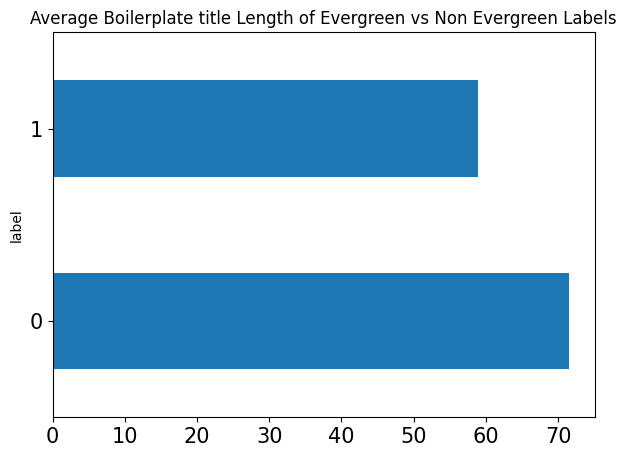

In [ ]:
df.groupby('label')['title_len'].mean().plot(kind = "barh",
         figsize = (7,5),
         fontsize = 15,
         title = "Average Boilerplate title Length of Evergreen vs Non Evergreen Labels")

<AxesSubplot: title={'center': 'body length exploration for evergreen vs epipheral'}, ylabel='label'>

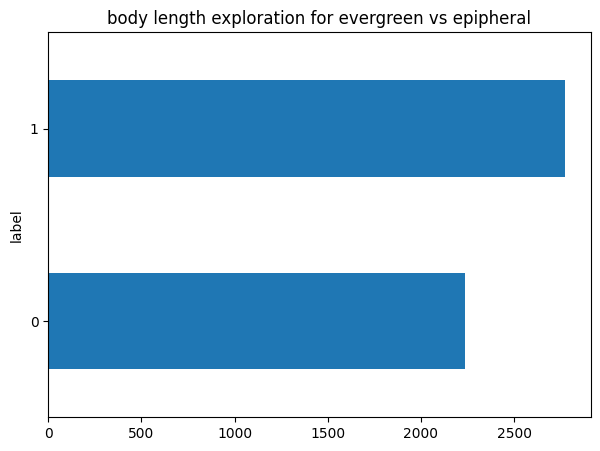

In [ ]:
df.groupby('label')['body_len'].mean().plot(kind='barh',figsize=(7,5),title="body length exploration for evergreen vs epipheral")

<AxesSubplot: title={'center': 'label proportions'}, ylabel='Frequency'>

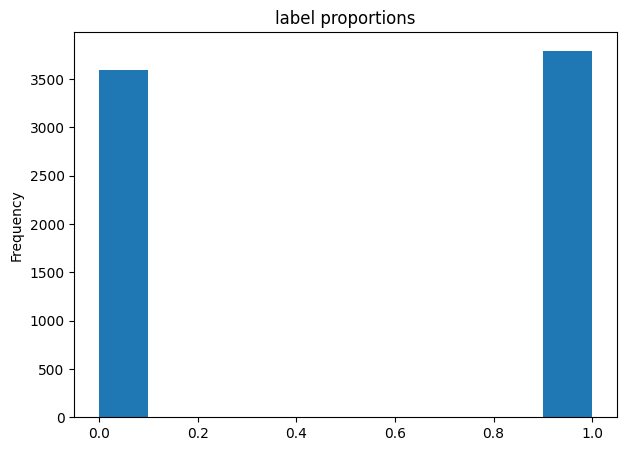

In [ ]:
df['label'].plot(kind='hist',figsize=(7,5),title="label proportions")
#0-epipheral 1=evergreen

In [ ]:
df['url']

0       http://www.bloomberg.com/news/2010-12-23/ibm-p...
1       http://www.popsci.com/technology/article/2012-...
2       http://www.menshealth.com/health/flu-fighting-...
3       http://www.dumblittleman.com/2007/12/10-foolpr...
4       http://bleacherreport.com/articles/1205138-the...
                              ...                        
7390    http://techcrunch.com/2010/09/08/kno-raises-46...
7391    http://www.uncoached.com/category/why-i-miss-c...
7392    http://eatthis.menshealth.com/slide/sweet-pota...
7393                            http://naturallyella.com/
7394    http://sportsillustrated.cnn.com/2011_swimsuit...
Name: url, Length: 7395, dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             7395 non-null   object 
 1   urlid                           7395 non-null   int64  
 2   boilerplate                     7395 non-null   object 
 3   alchemy_category                7395 non-null   object 
 4   alchemy_category_score          7395 non-null   object 
 5   avglinksize                     7395 non-null   float64
 6   commonlinkratio_1               7395 non-null   float64
 7   commonlinkratio_2               7395 non-null   float64
 8   commonlinkratio_3               7395 non-null   float64
 9   commonlinkratio_4               7395 non-null   float64
 10  compression_ratio               7395 non-null   float64
 11  embed_ratio                     7395 non-null   float64
 12  framebased                      73

In [ ]:
len(df)

7395

In [ ]:
df['alchemy_category'].value_counts()

?                     2342
recreation            1229
arts_entertainment     941
business               880
health                 506
sports                 380
culture_politics       343
computer_internet      296
science_technology     289
gaming                  76
religion                72
law_crime               31
unknown                  6
weather                  4
Name: alchemy_category, dtype: int64

<AxesSubplot: title={'center': 'exploration of alchemy_category'}, ylabel='alchemy_category,label'>

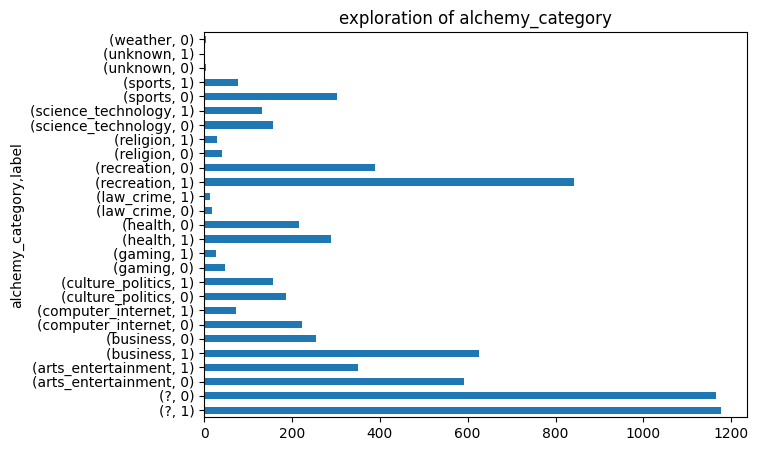

In [ ]:
df.groupby('alchemy_category')['label'].value_counts().plot(kind='barh',figsize=(7,5),title="exploration of alchemy_category")

In [ ]:
alchemy_key=list(df['alchemy_category'].value_counts().keys())

In [ ]:
alchemy_map={j:i for i,j in enumerate(alchemy_key)}

In [ ]:
df.alchemy_category=df['alchemy_category'].map(alchemy_map)

In [ ]:
df_tst.alchemy_category=df_tst['alchemy_category'].map(alchemy_map)

<AxesSubplot: title={'center': 'exploration of spelling_errors_ratio'}, ylabel='label'>

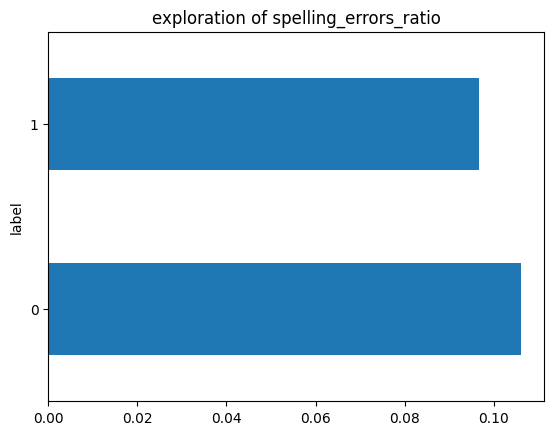

In [ ]:
df.groupby('label')['spelling_errors_ratio'].mean().plot(kind='barh',title='exploration of spelling_errors_ratio')

<AxesSubplot: title={'center': 'exploration of numwords in url'}, xlabel='label'>

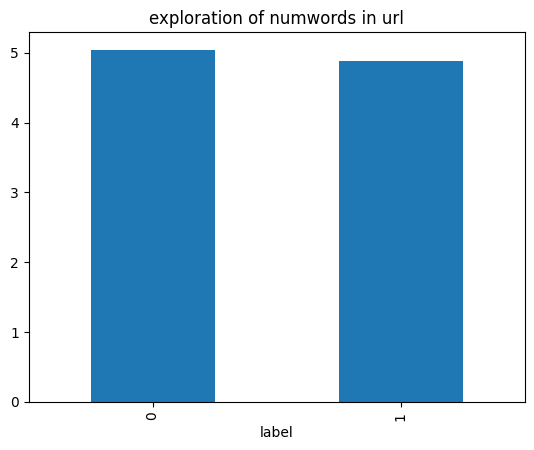

In [ ]:
df.groupby('label')['numwords_in_url'].mean().plot(kind='bar',title='exploration of numwords in url')

In [ ]:
from transformers import pipeline

In [ ]:
model_name="finiteautomata/bertweet-base-sentiment-analysis"
sent_model=pipeline(model=model_name)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [ ]:

sent_model('')

[{'label': 'NEU', 'score': 0.813655436038971}]

In [ ]:
def sentiment_title(x):
    dic={'POS':0,'NEU':1}
    if pd.isnull(x):
        x=''
    label=sent_model(x)[0]['label']
    if label in dic:
        return dic[label]
    else:
        return 2


In [ ]:
df['sent_title']=df['title'].apply(lambda x:sentiment_title(x))

In [ ]:
df_tst['sent_title']=df_tst['title'].apply(lambda x:sentiment_title(x))

<AxesSubplot: title={'center': 'exploration of setiment vs label'}, ylabel='label,sent_title'>

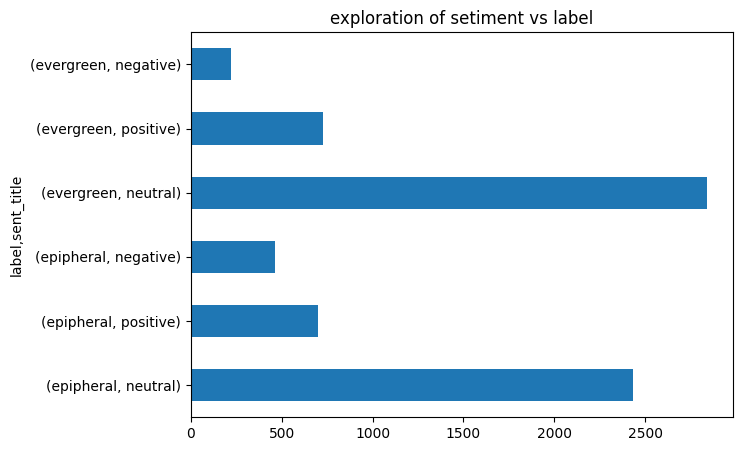

In [ ]:
df1=df.copy()
df1['label']=df1['label'].map({0:"epipheral",1:"evergreen"})
df1['sent_title']=df1['sent_title'].map({0:"positive",1:'neutral',2:"negative"})
df1.groupby('label')['sent_title'].value_counts().plot(kind='barh',figsize=(7,5),title='exploration of setiment vs label')

In [ ]:
del df1

In [ ]:
df.to_csv(file_path)

In [7]:

df=pd.read_csv(file_path)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      7395 non-null   int64  
 1   url                             7395 non-null   object 
 2   urlid                           7395 non-null   int64  
 3   boilerplate                     7395 non-null   object 
 4   alchemy_category                7395 non-null   object 
 5   alchemy_category_score          7395 non-null   object 
 6   avglinksize                     7395 non-null   float64
 7   commonlinkratio_1               7395 non-null   float64
 8   commonlinkratio_2               7395 non-null   float64
 9   commonlinkratio_3               7395 non-null   float64
 10  commonlinkratio_4               7395 non-null   float64
 11  compression_ratio               7395 non-null   float64
 12  embed_ratio                     73

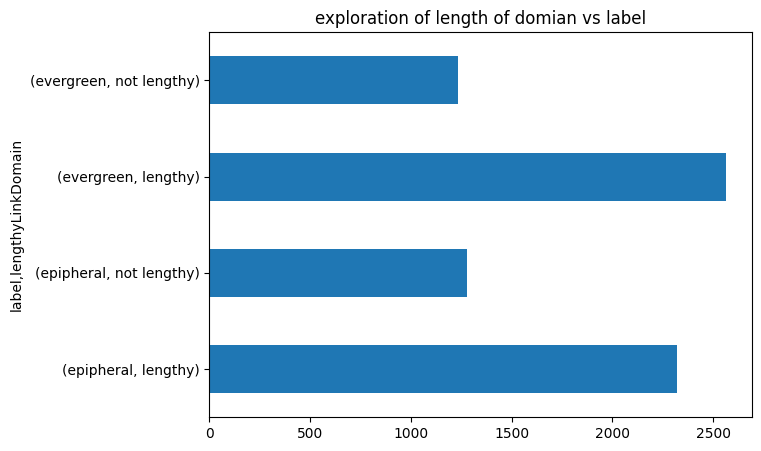

In [ ]:
copy_df=df.copy()
copy_df['label']=copy_df['label'].map({0:'epipheral',1:'evergreen'})
copy_df['lengthyLinkDomain']=copy_df['lengthyLinkDomain'].map({0:"not lengthy",1:"lengthy"})
copy_df.groupby('label')["lengthyLinkDomain"].value_counts().plot(kind='barh',figsize=(7,5),title="exploration of length of domian vs label")
del copy_df

<AxesSubplot: xlabel='label'>

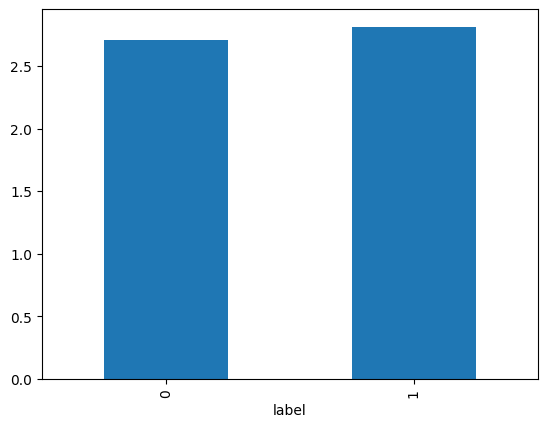

In [ ]:
df.groupby('label')['avglinksize'].mean().plot(kind='bar')

In [ ]:
df.alchemy_category_score.value_counts()

?            2342
0.85           82
0.0784091      40
0.849999       12
0.535009       10
             ... 
0.776397        1
0.351398        1
0.642615        1
0.640796        1
0.617876        1
Name: alchemy_category_score, Length: 4806, dtype: int64

**Feature Selection**

In [ ]:
num_features=df.drop(columns=['lengthyLinkDomain','avglinksize','title','body','url_b','news_front_page','is_news',"alchemy_category_score","url",'boilerplate',"Unnamed: 0",'label'])

In [ ]:
num_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   urlid                           7395 non-null   int64  
 1   alchemy_category                7395 non-null   int64  
 2   commonlinkratio_1               7395 non-null   float64
 3   commonlinkratio_2               7395 non-null   float64
 4   commonlinkratio_3               7395 non-null   float64
 5   commonlinkratio_4               7395 non-null   float64
 6   compression_ratio               7395 non-null   float64
 7   embed_ratio                     7395 non-null   float64
 8   framebased                      7395 non-null   int64  
 9   frameTagRatio                   7395 non-null   float64
 10  hasDomainLink                   7395 non-null   int64  
 11  html_ratio                      7395 non-null   float64
 12  image_ratio                     73

In [ ]:
y=df['label']

In [ ]:
y.value_counts()


1    3796
0    3599
Name: label, dtype: int64

**Train_test_split**

In [ ]:
sss=StratifiedShuffleSplit(n_splits=3,random_state=0,test_size=0.2)

In [ ]:
sss.get_n_splits(num_features,y)

3

In [ ]:
sss?

In [ ]:
xtrain=[]
for j in range(len(num_features)):
    xtr=[]
    for i in num_features:
        xtr.append(num_features[i][j])
    xtrain.append(xtr)
xtrain=np.asarray(xtrain)
xtrain.shape

(7395, 22)

In [ ]:
ytrain=np.asarray(list(df['label']))
ytrain=ytrain.reshape(7395,1)


**Building and Fitting on ML model**

In [ ]:
model=RandomForestClassifier(n_estimators=75,max_depth=20)
# model=SVC()
# model=CatBoostClassifier(**params)
# model=DecisionTreeClassifier()
# model=LogisticRegression()

In [ ]:
for i,j in sss.split(xtrain,ytrain):
#     print(i['train'])
    model.fit(xtrain[i],ytrain[i])
    pred=model.predict(xtrain[j])
    print(pred)
#     print(len(pred),len(ytrain[j].reshape(1479)))
    print(model.score(xtrain[j],ytrain[j]))


C:\Users\krish\AppData\Local\Temp\ipykernel_52120\4144360547.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain[i],ytrain[i])


[0 0 0 ... 0 0 1]
0.6869506423258959


C:\Users\krish\AppData\Local\Temp\ipykernel_52120\4144360547.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain[i],ytrain[i])


[1 1 1 ... 1 1 0]
0.6937119675456389


C:\Users\krish\AppData\Local\Temp\ipykernel_52120\4144360547.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(xtrain[i],ytrain[i])


[1 1 1 ... 0 0 0]
0.6788370520622042


In [ ]:
model.predict([xtrain[1001]])

array([1])

In [ ]:
xtrain[100]

array([7.47400000e+03, 1.00000000e+00, 6.91176471e-01, 2.72058824e-01,
       5.14705880e-02, 7.35294100e-03, 5.67322239e-01, 0.00000000e+00,
       0.00000000e+00, 3.74087590e-02, 0.00000000e+00, 1.41236939e-01,
       8.64077670e-01, 1.30000000e+01, 7.88300000e+03, 1.36000000e+02,
       4.00000000e+00, 3.52941176e-01, 1.04761905e-01, 3.10000000e+01,
       6.61000000e+02, 1.00000000e+00])

In [ ]:
ytrain[1001]

array([1])

In [ ]:
tst=df_tst[list(num_features.columns)]

In [ ]:
xtst=[]
for j in range(len(tst)):
    xtr=[]
    for i in tst:
        xtr.append(tst[i][j])
    xtst.append(xtr)
xtst=np.asarray(xtst)
xtst.shape

(3171, 22)

In [ ]:
tst_pred=model.predict(xtst)

In [ ]:
tst_pred

array([1, 0, 0, ..., 1, 0, 1])

In [5]:
df5=pd.read_csv("data\\sampleSubmission.csv")

In [ ]:
num_features.to_csv("data\\num_features.csv")
tst.to_csv("data\\tst.csv")

In [ ]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3171 entries, 0 to 3170
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   urlid   3171 non-null   int64
 1   label   3171 non-null   int64
dtypes: int64(2)
memory usage: 49.7 KB


In [ ]:
df5['label']=tst_pred

In [ ]:
df5.to_csv("data\\Submission.csv")

In [ ]:
df['title'][0]

'IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries'

In [8]:
df['text']=df['title']+". "+df['body']

In [9]:
df['text_len']=df['title_len']+df['body_len']

In [10]:
df['text_len'][0]

6317.0

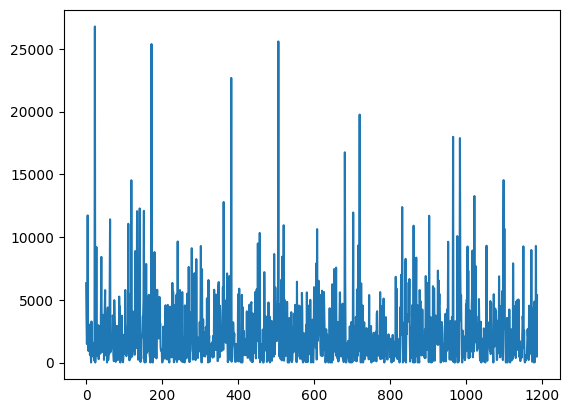

In [11]:
plt.plot(df['text_len'])

In [12]:
max(df['text_len'])

26775.0

In [13]:
min(df['text_len'])

2.0

In [14]:
df['text']=df.text.fillna(" ")

In [15]:
model_name='bert-base-uncased'

In [16]:
from transformers import AutoTokenizer

In [17]:
tk=AutoTokenizer.from_pretrained(model_name)

In [18]:
max_length=512
truncation=True
padding='max_length'

In [19]:
tk(df['text'][1],max_length=max_length,padding=padding,truncation=truncation)

{'input_ids': [101, 1996, 3929, 4816, 28971, 3225, 3282, 2008, 11027, 2015, 12637, 1999, 3837, 1996, 3929, 4816, 1010, 28971, 3225, 3282, 2008, 11027, 2015, 12637, 1999, 3837, 1996, 3929, 4816, 1010, 28971, 3225, 3282, 2008, 11027, 2015, 12637, 1999, 3837, 1012, 1998, 2008, 2064, 2022, 3344, 2006, 1037, 4946, 2302, 1996, 2038, 25016, 2205, 1996, 14827, 1041, 3282, 3225, 8779, 14827, 2009, 1055, 3733, 2000, 2202, 2005, 4379, 2074, 2129, 9577, 2135, 2485, 2070, 4386, 3837, 2024, 1998, 2129, 2172, 1996, 8117, 21823, 6679, 1997, 2009, 2035, 2064, 3043, 1996, 3819, 2742, 2003, 1996, 3151, 3225, 3282, 3849, 3733, 2017, 4139, 1037, 9495, 1998, 1996, 2679, 4627, 8797, 2054, 2111, 2123, 1056, 5136, 2043, 1037, 7511, 3282, 3632, 2125, 1996, 2614, 7930, 2000, 1996, 5551, 1997, 1996, 7541, 5479, 1037, 12884, 1997, 1037, 2117, 10076, 2084, 1996, 2500, 2008, 1055, 2074, 2438, 2000, 3043, 1998, 2339, 1996, 6745, 3225, 8779, 2038, 7007, 1999, 1996, 6228, 8797, 2005, 23339, 4816, 5005, 14827, 2038, 204

In [20]:

len(df)

1189

**Tokenizing Text**

In [21]:

def tokenize(df):
    xtrain_inp=np.zeros((len(df),max_length))
    xtrain_mask=np.zeros((len(df),max_length))
    for i in range(len(df['text'])):
        txt=df['text'][i]
        xt=tk(txt,max_length=max_length,padding=padding,truncation=truncation)
        xtrain_inp[i,:]=xt['input_ids']
        xtrain_mask[i,:]=xt['attention_mask']
    dic={}
    dic['input_ids']=xtrain_inp
    dic['attention_mask']=xtrain_mask
    return dic

In [22]:
x_train=tokenize(df)

In [23]:
x_train['attention_mask'].shape

(1189, 512)

In [24]:
x_train

{'input_ids': array([[  101.,  9980.,  5927., ..., 16333.,  5840.,   102.],
        [  101.,  1996.,  3929., ...,  2707.,  1997.,   102.],
        [  101., 10962.,  2008., ...,     0.,     0.,     0.],
        ...,
        [  101., 12098.,  5603., ...,     0.,     0.,     0.],
        [  101.,  9556.,  2006., ..., 17779.,  2015.,   102.],
        [  101.,  2459.,  6581., ...,  7603.,  2566.,   102.]]),
 'attention_mask': array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]])}

In [25]:
def con_to_tens(xtrain,label):
    label=np.asarray(label).reshape(len(label),1)
    label=tf.constant(label)
    x=tf.data.Dataset.from_tensor_slices((x_train,label))
    return x

In [26]:
train_data=con_to_tens(x_train,df['label'])

In [27]:
train_data

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [28]:
batch_size=16


In [29]:
batched_train_data=train_data.batch(batch_size,drop_remainder=True)

In [30]:
len(batched_train_data)

74

In [31]:
# from transformers import DistilBertConfig
# config=DistilBertConfig(dropout=0.2, attention_dropout=0.2)
# config.output_hidden_states = False
dis_bert=TFAutoModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [32]:
train_size=0.8


In [33]:

train_batch=batched_train_data.take(int(train_size*len(batched_train_data)))
test_batch=batched_train_data.skip(int(train_size*len(batched_train_data)))

In [34]:
int(train_size*len(batched_train_data))

59

In [35]:
len(train_batch),len(test_batch)

(59, 15)

**Model Building and Training**

In [36]:
# K.set_learning_phase(0)
inp=Input(shape=(512,),name='input_ids',dtype='int32')
inp1=Input(shape=(512,),name='attention_mask',dtype='int32')

bert_wt=dis_bert.bert(inp,attention_mask=inp1)[0]
# bert_wt=tf.keras.layers.Embedding(60000,100,input_length=512)(inp)

x1=LSTM(128,return_sequences=True)(bert_wt)
x1=Dropout(0.4)(x1)
x=LSTM(128)(x1)
x=Dropout(0.4)(x)
x=Dense(128,activation='relu')(x)
x=Dropout(0.4)(x)
x=Dense(32,activation='relu')(x)
x=Dense(1,activation='sigmoid')(x)

In [37]:
model=tf.keras.Model(inputs=[inp,inp1],outputs=x)

In [38]:
for i in model.layers[:3]:
    i.trainable=False

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [40]:
from tensorflow.keras.utils import plot_model

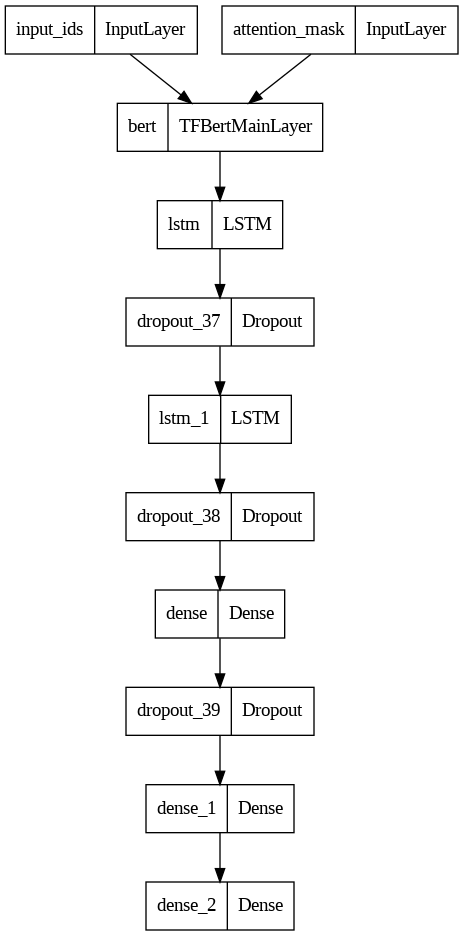

In [41]:
plot_model(model)

In [42]:
from tensorflow.keras.optimizers import AdamW

In [43]:
model.compile(optimizer=AdamW(0.01),loss='binary_crossentropy',metrics=['accuracy'])

In [50]:
callback=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=2,min_delta=0.02)


In [51]:

history=model.fit(train_batch,epochs=10,validation_data=test_batch,callbacks=[callback])

Epoch 1/10
59/59 [==============================] - 56s 948ms/step - loss: 0.5281 - accuracy: 0.7733 - val_loss: 0.5302 - val_accuracy: 0.7708
Epoch 2/10
59/59 [==============================] - 58s 985ms/step - loss: 0.4927 - accuracy: 0.7871 - val_loss: 0.5082 - val_accuracy: 0.7875
Epoch 3/10
59/59 [==============================] - 58s 986ms/step - loss: 0.5100 - accuracy: 0.7797 - val_loss: 0.5539 - val_accuracy: 0.7875
Epoch 4/10
59/59 [==============================] - 59s 1s/step - loss: 0.5207 - accuracy: 0.7934 - val_loss: 0.5420 - val_accuracy: 0.7667


In [ ]:
train_batch.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 1), dtype=tf.int64, name=None))>

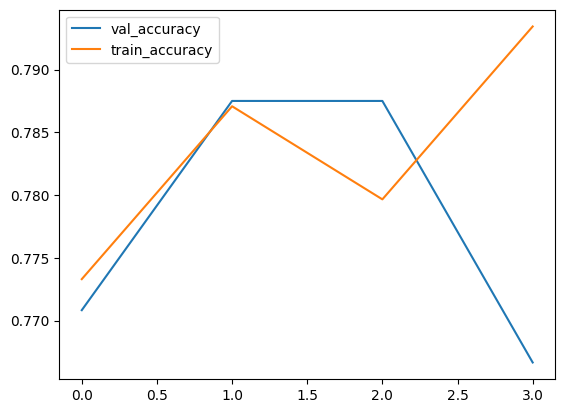

In [61]:
from matplotlib import pyplot as plt
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.plot(history.history['accuracy'],label='train_accuracy')
plt.legend()
plt.show()

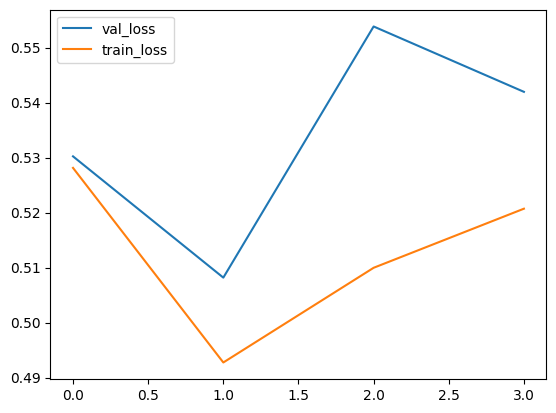

In [62]:
from matplotlib import pyplot as plt
plt.plot(history.history['val_loss'],label='val_loss')
plt.plot(history.history['loss'],label='train_loss')
plt.legend()
plt.show()

**predicting** **on** **test** **set**

In [ ]:

test_batch

<_SkipDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 1), dtype=tf.int64, name=None))>

In [ ]:
list(train_batch.take(1).as_numpy_iterator())[0][0]['input_ids'][0]

array([  101.,  9980.,  5927.,  7570., 21197., 20721.,  4455.,  2250.,
        5505., 10274.,  9980.,  5927.,  7570., 21197., 20721.,  4455.,
        1010.,  2250.,  1011.,  5505., 10274.,  1012.,  1037.,  3696.,
        4832.,  2648.,  1996.,  2248.,  2449.,  6681., 13058.,  9980.,
       11346.,  4181.,  2470.,  2415.,  3721.,  1999.,  2624.,  4560.,
        2662.,  8088.,  4116., 13642.,  8017., 22950.,  3121.,  3233.,
        2012.,  1996.,  2248.,  2449.,  6681., 13058.,  9980., 11346.,
        4181.,  2470.,  2415.,  3721.,  1999.,  1996.,  4203., 12409.,
        4564.,  1997.,  2624.,  4560.,  2662.,  8088.,  4116., 13642.,
        8017., 22950.,  2011.,  2325.,  2115.,  4684.,  3042.,  2097.,
        2622.,  1037.,  1017.,  1040.,  3746.,  1997.,  3087.,  2040.,
        4455.,  1998.,  2115., 12191.,  2097.,  2022.,  6113.,  2011.,
       20504.,  2943.,  2012.,  2560.,  2008.,  1055.,  2054.,  2248.,
        2449.,  6681., 13058.,  5927.,  1999.,  2049.,  6121.,  3608.,
      

In [ ]:
list(train_batch.take(1).as_numpy_iterator())[0][1][0]

array([0])

In [ ]:
df_tst['text']=df_tst["title"]+". "+df_tst["body"]
df_tst['text']=df_tst['text'].fillna(" ")

In [ ]:
x_tst=tokenize(df_tst)

In [ ]:
predictions=list(model.predict(x_tst))

100/100 [==============================] - 134s 1s/step


In [ ]:
predictions

[array([0.9162407], dtype=float32),
 array([0.3351364], dtype=float32),
 array([0.43790546], dtype=float32),
 array([0.10347059], dtype=float32),
 array([0.44805962], dtype=float32),
 array([0.4729918], dtype=float32),
 array([0.55667967], dtype=float32),
 array([0.8995923], dtype=float32),
 array([0.11104872], dtype=float32),
 array([0.40330365], dtype=float32),
 array([0.5341406], dtype=float32),
 array([0.5341406], dtype=float32),
 array([0.10066048], dtype=float32),
 array([0.40700084], dtype=float32),
 array([0.3096247], dtype=float32),
 array([0.55680394], dtype=float32),
 array([0.8921577], dtype=float32),
 array([0.84580547], dtype=float32),
 array([0.91888964], dtype=float32),
 array([0.10779551], dtype=float32),
 array([0.86692125], dtype=float32),
 array([0.70899206], dtype=float32),
 array([0.9310435], dtype=float32),
 array([0.11109086], dtype=float32),
 array([0.10148157], dtype=float32),
 array([0.5056445], dtype=float32),
 array([0.54292774], dtype=float32),
 array([0.5

In [ ]:
pred=[]
for i in predictions:
  if i>=0.5:
    pred.append(1)
  else:
    pred.append(0)

In [ ]:
df2=pd.read_csv("data/sampleSubmission.csv")

In [ ]:
df2['label']=pred

In [ ]:
df2.to_csv("data/Submission1.csv",index=False)

In [63]:
model.save('stumble_upon.h5')
